# Project 4 - Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Project Dependencies

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
%matplotlib inline

## Camera Calibration

**Requirement: Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.**

First the calibration images are loaded from disk and placed into an array.

Placeholder arrays are created to store the chessboard 3D (`x,y,z`) coordinates (`obj_points`), and to store pixel positions of successfully detected chessboard corners (`img_points`).

In [2]:
### Read in calibaration images ###
def load_cal_images():
    images = []
    for i in range(1, 21):
        path = 'camera_cal/calibration{}.jpg'.format(i)
        img = mpimg.imread(path,)        
        images.append(img)

    return np.array(images)

cal_images = load_cal_images()

# Store object points and image points 
obj_points = []
img_points = []

# Prepare object points for 6x9 checkerboard
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

`order_points()` takes in an array of points where chessboard corners have been detected, selects points defining the top left, top right, bottom left and bottom right corners of an image. 

In [3]:
""" Reference: http://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/ """ 

def order_points(pts):        
    
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
        
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)

    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    # return the ordered coordinates
    return rect

`find_corners()` converts input images to grayscale and uses OpenCV's `findChessboardCorners` method to detect corner points in each image. 

In [4]:
### Find Chessboard Corners ###
def find_corners(image):        
    # Convert to grayscale
    gray = np.copy(image)
    gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # Add object points and image points
    if ret == True:                
        img_points.append(corners)
        obj_points.append(objp)
        
        return corners

cal_corners = find_corners(cal_images[2])

`obj_points` and `img_points` are used to calculate camera calibration and distortion coefficients with OpenCV's `calibrateCamera()` function.

In [5]:
def undistort(image):
    # Undistort
    copy = np.copy(image)
    gray = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::], None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
undistort(cal_images[2])

Get perspective transform using and warp image to obtain a frontal view of undistorted chessboard image.

In [6]:
def unwarp_chessboard(image, corners):
    pts = []
    for point in corners:
        vals = point[0]
        pts.append(vals)

    offset = 0
    img_size = (1280, 720)
    
    pts = np.array(pts)
    src = order_points(pts)
    
    # Select destination points for transform
    dst_TL = [offset, offset]
    dst_TR = [img_size[0], offset]
    dst_BR = [img_size[0], img_size[1]]
    dst_BL = [offset, img_size[1]]

    dst = np.float32([dst_TL, dst_TR, dst_BR, dst_BL])
    
    # Perform perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

undistorted_warp = unwarp_chessboard(cal_images[2], cal_corners)

In [7]:
### Save Corrected Images ###
def save_corrected(image):
    mpimg.imsave('output_images/undistorted_chessboard.jpg', image)

save_corrected(undistorted_warp)

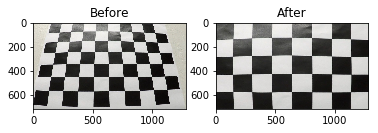

In [8]:
# Plot example original and undistorted images
plt.subplot(1,2,1)
plt.title('Before')
dist = plt.imshow(cal_images[2])

plt.subplot(1,2,2)
plt.title('After')
cal = plt.imshow(undistorted_warp, cmap='gray')

plt.show()

## Image Pipeline

Images are loaded from disk and a utitility method is used to save processed images to the `output_images` folder.

In [9]:
test_images = []

def load_test_images():
    images = []
    for path in glob.glob('test_images/*.jpg'):
        img = mpimg.imread(path)
        images.append(img)
    
    return images
    
def save_images(images, title):
    for i in range(0, len(images)):
        mpimg.imsave('output_images/{}{}.jpg'.format(title,i+1),images[i])
        
test_images = load_test_images()

**Requirement:  Provide an example of a distortion-corrected image.**

Test images are undistorted, added to the `undist_test_images` array and saved to the `output_images` folder as `undistorted_test<x>.jpg`

In [10]:
def undistort_test(images):
    undist_images = []
    for image in images:
        undist = np.copy(image)
        undistort(undist)
        undist_images.append(undist)
    return undist_images

undist_test_images = undistort_test(test_images)
save_images(undist_test_images, 'undistorted_test')

### Apply Thresholding

**Requirement: Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.**

Various thresholding techniques are applied to the undistorted test images in order to find an effective combination of techniques to effectively discern lane lines.

In [11]:
test_image = undist_test_images[0]

In [12]:
def threshold_blue(image):
    copy = np.copy(image)
    b = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
#     clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
#     b = clahe.apply(b)
    
    b = copy[:,:,1]
    
    # Threshold color channel
    b_thresh_min = 30
    b_thresh_max = 190
    b_binary = np.ones_like(b)
    b_binary[(b >= b_thresh_min) & (b <= b_thresh_max)] = 0
    
    return b_binary
    
def apply_blue():
    blues = []
    for image in undist_test_images:
        processed = threshold_blue(image)
        blues.append(processed)
    return blues

blues = apply_blue()
save_images(blues, 'thresholded_blue')

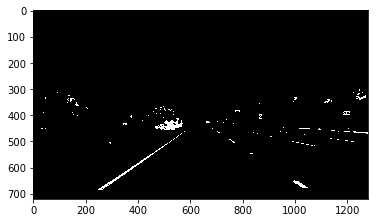

In [13]:
plt.imshow(blues[0], cmap='gray')

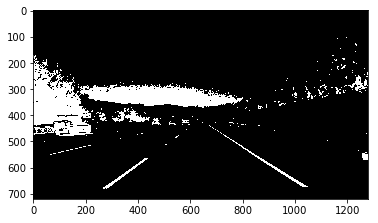

In [14]:
plt.imshow(blues[1], cmap='gray')

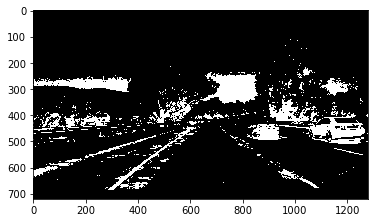

In [15]:
plt.imshow(blues[2], cmap='gray')

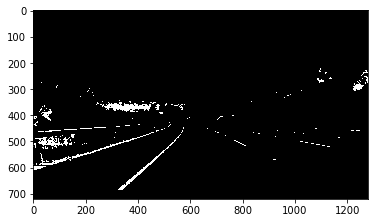

In [16]:
plt.imshow(blues[3], cmap='gray')

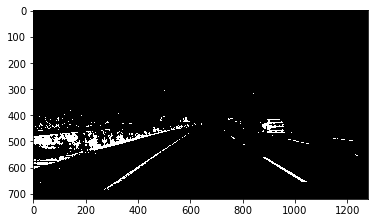

In [17]:
plt.imshow(blues[4], cmap='gray')

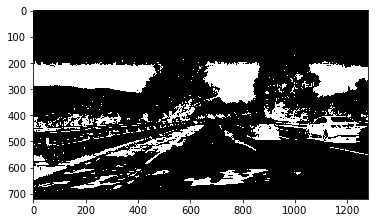

In [18]:
plt.imshow(blues[5], cmap='gray')

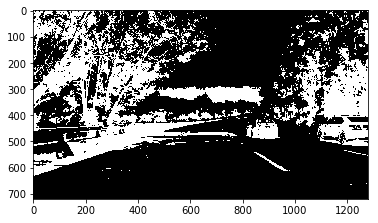

In [19]:
plt.imshow(blues[6], cmap='gray')

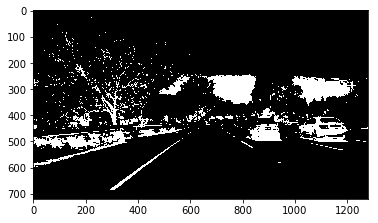

In [20]:
plt.imshow(blues[7], cmap='gray')

In [21]:
def threshold_green(image):
    copy = np.copy(image)
    g = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    g = copy[:,:,1]
    
    # Threshold color channel
    g_thresh_min = 60
    g_thresh_max = 200

    g_binary = np.ones_like(g)
    g_binary[(g >= g_thresh_min) & (g <= g_thresh_max)] = 0
    
    return g_binary

def apply_green():
    greens = []
    for image in undist_test_images:
        processed = threshold_green(image)
        greens.append(processed)
    return greens

greens = apply_green()
save_images(greens, 'thresholded_green')

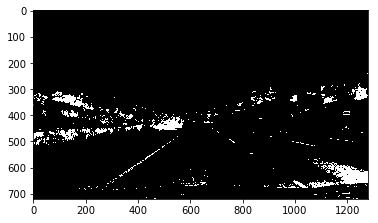

In [22]:
plt.imshow(greens[0], cmap='gray')

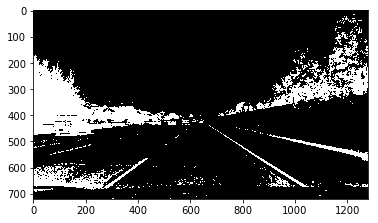

In [23]:
plt.imshow(greens[1], cmap='gray')

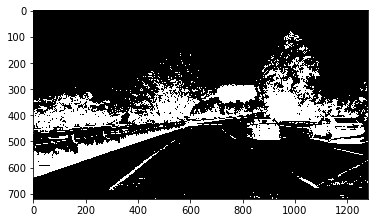

In [24]:
plt.imshow(greens[2], cmap='gray')

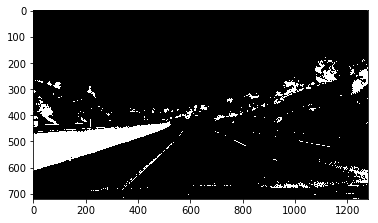

In [25]:
plt.imshow(greens[3], cmap='gray')

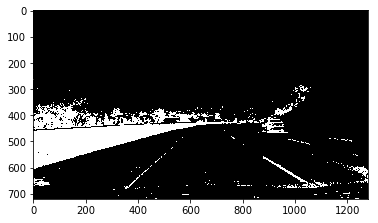

In [26]:
plt.imshow(greens[4], cmap='gray')

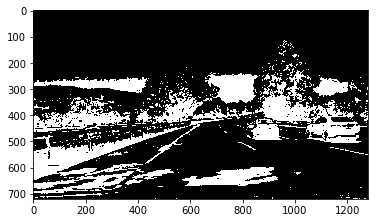

In [27]:
plt.imshow(greens[5], cmap='gray')

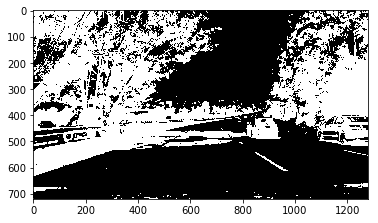

In [28]:
plt.imshow(greens[6], cmap='gray')

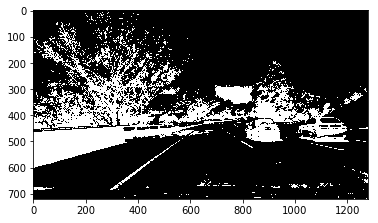

In [29]:
plt.imshow(greens[7], cmap='gray')

#### R Channel Thresholding

In [30]:
def threshold_red(image):
    copy = np.copy(image)
    r = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    r = copy[:,:,0]
    
    # Threshold color channel
    r_thresh_min = 50
    r_thresh_max = 210
    r_binary = np.ones_like(r)
    r_binary[(r >= r_thresh_min) & (r <= r_thresh_max)] = 0
    
    return r_binary

def apply_red():
    reds = []
    for image in undist_test_images:
        processed = threshold_red(image)
        reds.append(processed)
    return reds

reds = apply_red()
save_images(reds, 'thresholded_red')

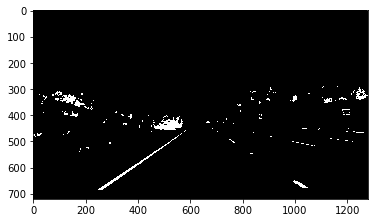

In [31]:
plt.imshow(reds[0], cmap='gray')

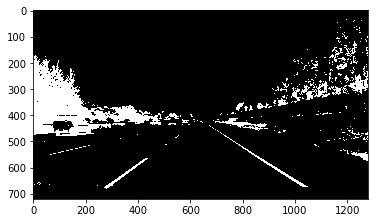

In [32]:
plt.imshow(reds[1], cmap='gray')

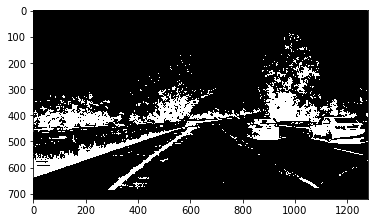

In [33]:
plt.imshow(reds[2], cmap='gray')

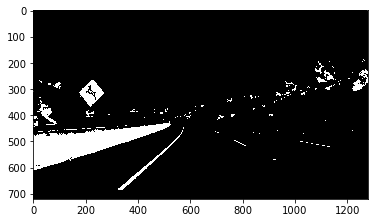

In [34]:
plt.imshow(reds[3], cmap='gray')

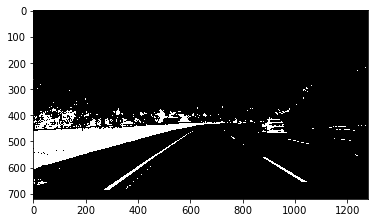

In [35]:
plt.imshow(reds[4], cmap='gray')

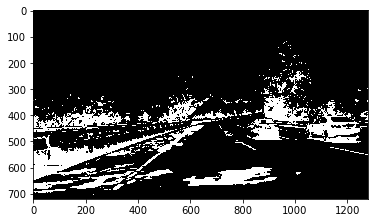

In [36]:
plt.imshow(reds[5], cmap='gray')

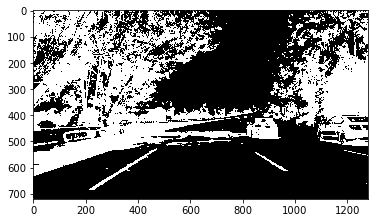

In [37]:
plt.imshow(reds[6], cmap='gray')

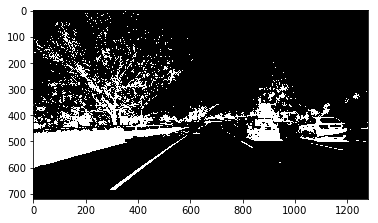

In [38]:
plt.imshow(reds[7], cmap='gray')

#### H Thresholding

In [39]:
def threshold_h(image):
    copy = np.copy(image)
    h = cv2.cvtColor(copy, cv2.COLOR_RGB2HLS)
    h = copy[:,:,1]
    
    # Threshold color channel
    h_thresh_min = 50
    h_thresh_max = 200
    h_binary = np.ones_like(h)
    h_binary[(h >= h_thresh_min) & (h <= h_thresh_max)] = 0
    
    return h_binary
        
def apply_h():
    h_images = []
    for image in undist_test_images:
        processed = threshold_h(image)
        h_images.append(processed)

    return h_images

h_images = apply_h()
save_images(h_images, 'thresholded_hue')

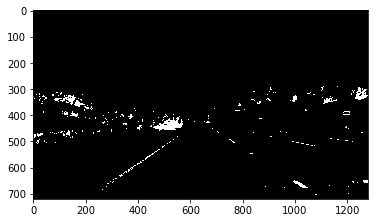

In [40]:
plt.imshow(h_images[0], cmap='gray')

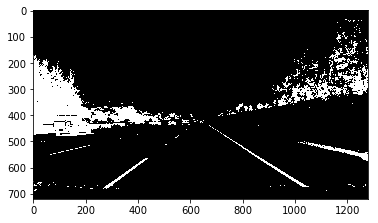

In [41]:
plt.imshow(h_images[1], cmap='gray')

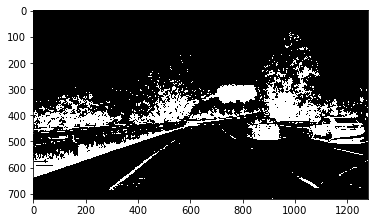

In [42]:
plt.imshow(h_images[2], cmap='gray')

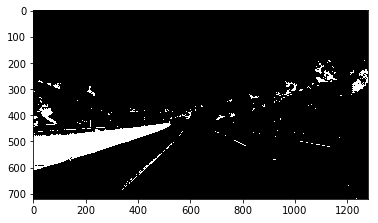

In [43]:
plt.imshow(h_images[3], cmap='gray')

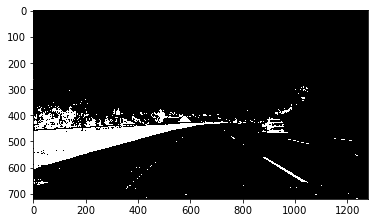

In [44]:
plt.imshow(h_images[4], cmap='gray')

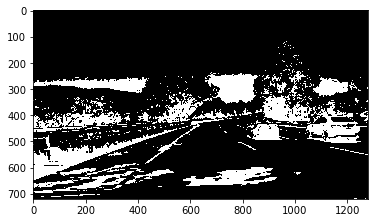

In [45]:
plt.imshow(h_images[5], cmap='gray')

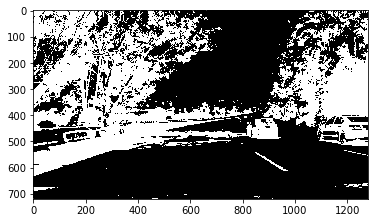

In [46]:
plt.imshow(h_images[6], cmap='gray')

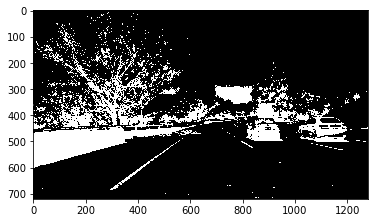

In [47]:
plt.imshow(h_images[7], cmap='gray')

#### L Thresholding

In [48]:
def threshold_l(image):
    copy = np.copy(image)
    l = cv2.cvtColor(copy, cv2.COLOR_RGB2HLS)
    l = copy[:,:,1]
    
    # Threshold color channel
    l_thresh_min = 60
    l_thresh_max = 200
    l_binary = np.ones_like(l)
    l_binary[(l >= l_thresh_min) & (l <= l_thresh_max)] = 0
    
    return l_binary
        
def apply_l():
    l_images = []
    for image in undist_test_images:
        processed = threshold_l(image)
        l_images.append(processed)

    return l_images

l_images = apply_l()
save_images(l_images, 'thresholded_lightness')

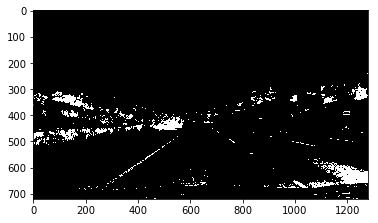

In [49]:
plt.imshow(l_images[0], cmap='gray')

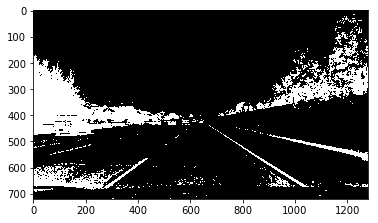

In [50]:
plt.imshow(l_images[1], cmap='gray')

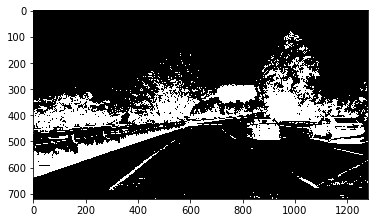

In [51]:
plt.imshow(l_images[2], cmap='gray')

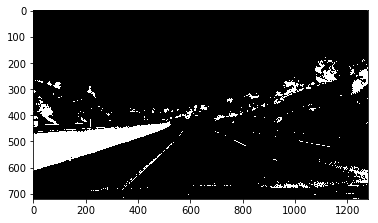

In [52]:
plt.imshow(l_images[3], cmap='gray')

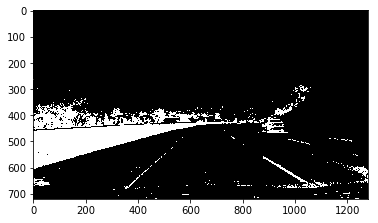

In [53]:
plt.imshow(l_images[4], cmap='gray')

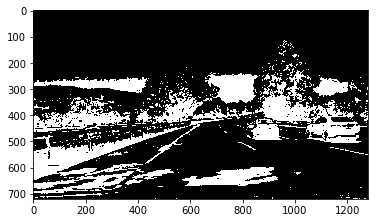

In [54]:
plt.imshow(l_images[5], cmap='gray')

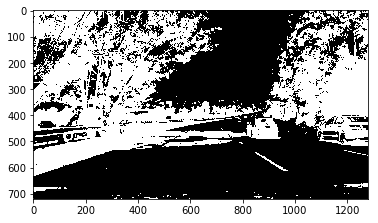

In [55]:
plt.imshow(l_images[6], cmap='gray')

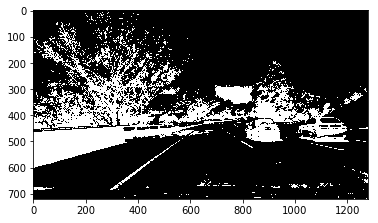

In [56]:
plt.imshow(l_images[7], cmap='gray')

#### S Thresholding

In [57]:
### HLS Thresholding ###
def threshold_s(image):
    copy = np.copy(image)
    s = cv2.cvtColor(copy, cv2.COLOR_RGB2HLS)
    s = copy[:,:,2]
    
    # Threshold color channel
    s_thresh_min = 60
    s_thresh_max = 200
    s_binary = np.ones_like(s)
    s_binary[(s >= s_thresh_min) & (s <= s_thresh_max)] = 0
    
    return s_binary
        
def apply_s():
    s_images = []
    for image in undist_test_images:
        processed = threshold_s(image)
        s_images.append(processed)

    return s_images

s_images = apply_s()

save_images(s_images, 'thresholded_saturation')

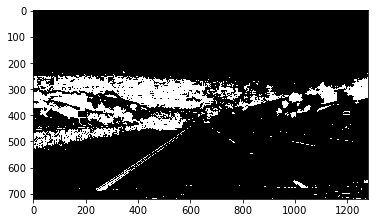

In [58]:
plt.imshow(s_images[0], cmap='gray')

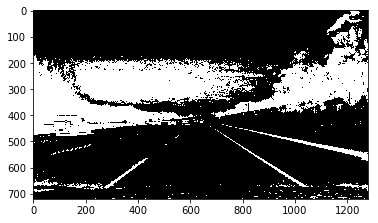

In [59]:
plt.imshow(s_images[1], cmap='gray')

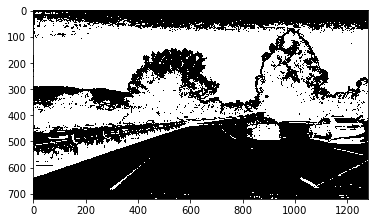

In [60]:
plt.imshow(s_images[2], cmap='gray')

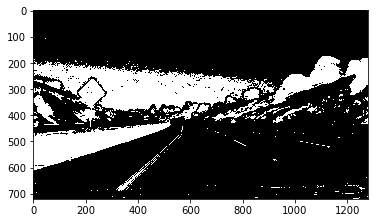

In [61]:
plt.imshow(s_images[3], cmap='gray')

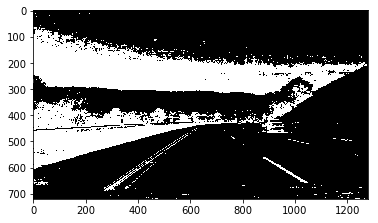

In [62]:
plt.imshow(s_images[4], cmap='gray')

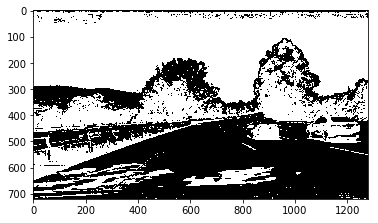

In [63]:
plt.imshow(s_images[5], cmap='gray')

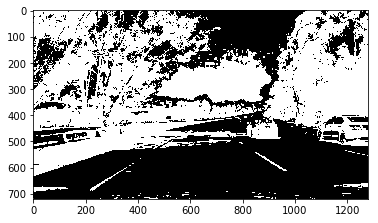

In [64]:
plt.imshow(s_images[6], cmap='gray')

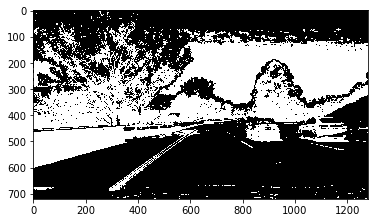

In [65]:
plt.imshow(s_images[7], cmap='gray')

#### Absolute Thresholding

In [66]:
### Abs Thresholding ###
def threshold_abs(image):
    copy = np.copy(image)
    gray = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    
    kernel = 7 #15
    
    # Absolute X
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 
    
    x_min = 20
    x_max = 255
    
    # Absolute Y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    abs_sobely = np.absolute(sobelx)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    y_min = 20
    y_max = 255
    
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= x_min) & (scaled_sobelx <= x_max)] = 1
    
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= y_min) & (scaled_sobely <= y_max)] = 1
    
    sbinary = np.zeros_like(scaled_sobelx)
    sbinary[((scaled_sobely >= y_min) & (scaled_sobely <= y_max) & ((scaled_sobelx >= x_min) & (scaled_sobelx <= x_max)))] = 1
    
    return sbinary

def apply_abs():
    abs_images = []
    for image in undist_test_images:
        processed = threshold_abs(image)
        abs_images.append(processed)
        
    return abs_images

abs_images = apply_abs()
save_images(abs_images, 'thresholded_abs_sobel')

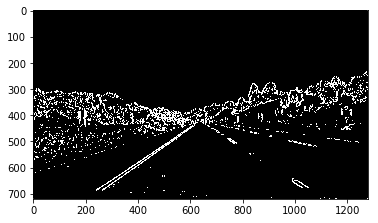

In [67]:
plt.imshow(abs_images[0], cmap='gray')

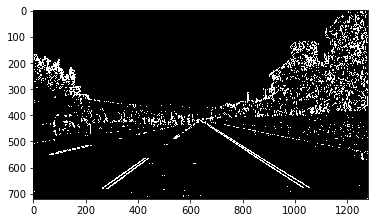

In [68]:
plt.imshow(abs_images[1], cmap='gray')

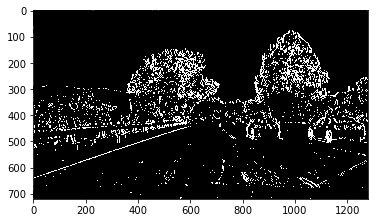

In [69]:
plt.imshow(abs_images[2], cmap='gray')

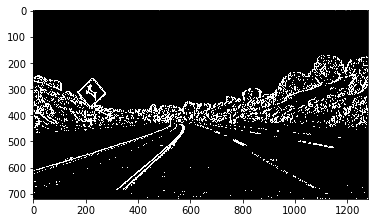

In [70]:
plt.imshow(abs_images[3], cmap='gray')

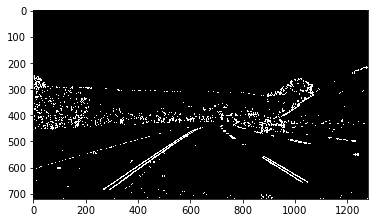

In [71]:
plt.imshow(abs_images[4], cmap='gray')

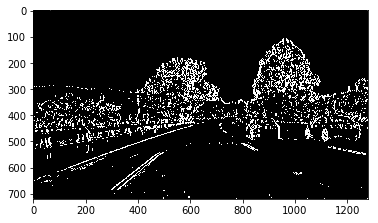

In [72]:
plt.imshow(abs_images[5], cmap='gray')

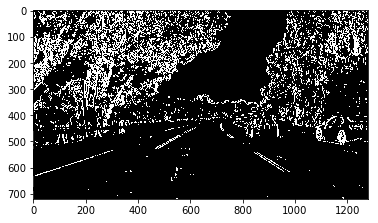

In [73]:
plt.imshow(abs_images[6], cmap='gray')

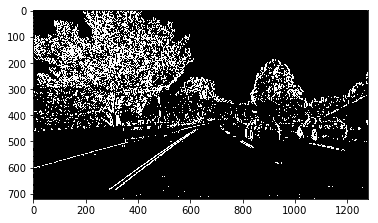

In [74]:
plt.imshow(abs_images[7], cmap='gray')

#### Sobel X  Thresholding

In [75]:
### Sobel X Thresholding ###
def threshold_direction(image):
    copy = np.copy(image)
    gray = cv2.cvtColor(copy, cv2.COLOR_RGB2HLS)
    gray = gray[:,:,2]
    
    kernel = 7 #31
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)

    dir_min = 0.8
    dir_max = 1.1
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= dir_min) & (dir_sobel <= dir_max)] = 1
    
    return dir_binary

def apply_direction():
    sobel_images = []
    for image in undist_test_images:
        processed = threshold_direction(image)
        sobel_images.append(processed)
    return sobel_images

direction_images = apply_direction()
save_images(direction_images, 'sobel_directions')

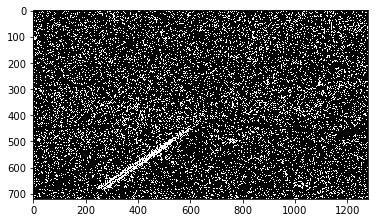

In [76]:
plt.imshow(direction_images[0], cmap='gray')

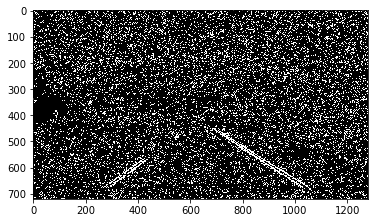

In [77]:
plt.imshow(direction_images[1], cmap='gray')

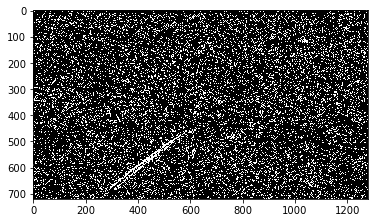

In [78]:
plt.imshow(direction_images[2], cmap='gray')

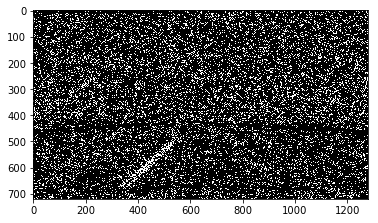

In [79]:
plt.imshow(direction_images[3], cmap='gray')

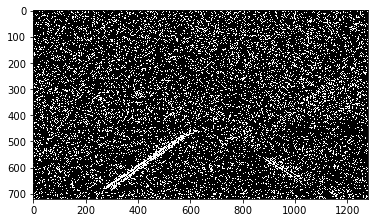

In [80]:
plt.imshow(direction_images[4], cmap='gray')

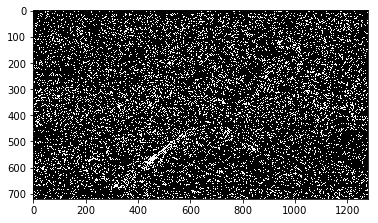

In [81]:
plt.imshow(direction_images[5], cmap='gray')

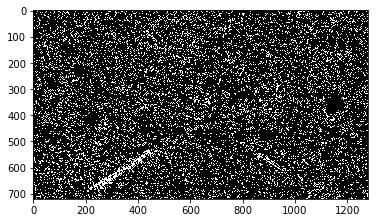

In [82]:
plt.imshow(direction_images[6], cmap='gray')

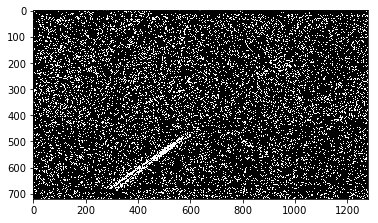

In [83]:
plt.imshow(direction_images[7], cmap='gray')

#### Mangitude Thresholding

In [84]:
### Sobel Magnitude Thresholding ###
def threshold_magnitude(image):
    copy = np.copy(image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = 7# 15
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)

    mag = np.sqrt(np.square(sobelx) + np.square(sobely))

    scaled_sobel = np.uint8(255*mag/np.max(mag))

    mag_min = 50
    mag_max = 255
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_min) & (scaled_sobel <= mag_max)] = 1

    return mag_binary

def apply_magnitude():
    mag_images = []
    for image in undist_test_images:
        processed = threshold_magnitude(image)
        mag_images.append(processed)
        
    return mag_images

mag_images = apply_magnitude()
save_images(mag_images, 'sobel_magnitude')

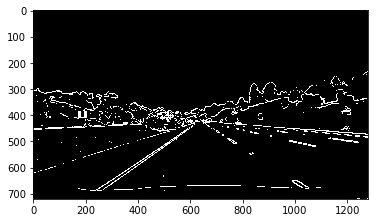

In [85]:
plt.imshow(mag_images[0], cmap='gray')

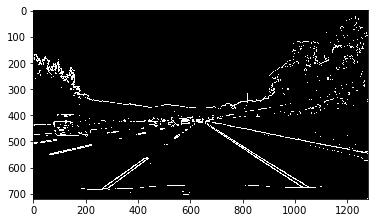

In [86]:
plt.imshow(mag_images[1], cmap='gray')

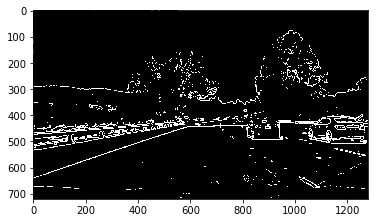

In [87]:
plt.imshow(mag_images[2], cmap='gray')

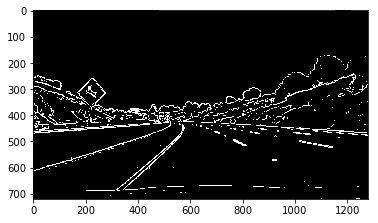

In [88]:
plt.imshow(mag_images[3], cmap='gray')

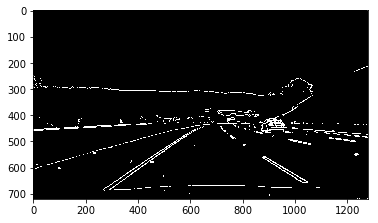

In [89]:
plt.imshow(mag_images[4], cmap='gray')

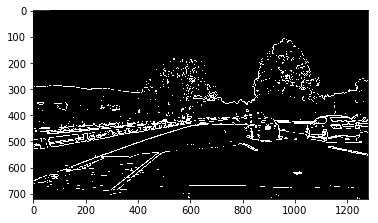

In [90]:
plt.imshow(mag_images[5], cmap='gray')

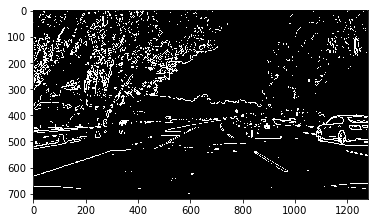

In [91]:
plt.imshow(mag_images[6], cmap='gray')

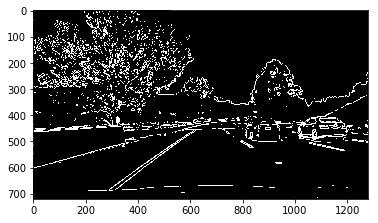

In [92]:
plt.imshow(mag_images[7], cmap='gray')

#### Combine Thresholds

The final solution combines five thresholding techniques:
1. HLS S channel
2. RGB R channel
3. Absolute Sobel 
4. Sobel Direction
5. Sobel Magnitude

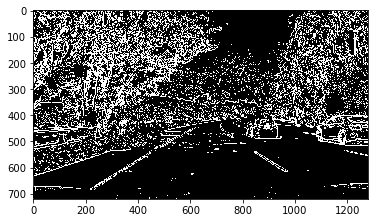

In [93]:
### Combine Thresholds ###
def combine_thresholds(binary_s, binary_r, binary_abs, binary_dir, binary_mag):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(binary_s)
    
    # Intermediate combinations #
    srm_bin = np.zeros_like(combined_binary)
    srm_bin[((binary_s == 1) | (binary_r == 1)) | (binary_mag == 1)] = 1

    out_bin = np.zeros_like(combined_binary)
    out_bin[((((binary_mag == 1) | (binary_dir == 1)) | (binary_abs == 1))) & (srm_bin == 1)] = 1
        
    return out_bin

def apply_combination():
    combined_images = []
    for image in undist_test_images:
        
        """
        Created binaries using various thresholding techniques to determine
        which would produce the best results.
        """
        
        # HLS #
        s_binary = threshold_s(image)
        
        # RGB #
        r_binary = threshold_red(image)
        
        # Sobel #
        abs_binary = threshold_abs(image)
        dir_binary = threshold_direction(image)
        mag_binary = threshold_magnitude(image)
    
        # Combine final output #
        combined = combine_thresholds(s_binary, r_binary, abs_binary, dir_binary, mag_binary)
        combined_images.append(combined)
        
    return combined_images


def save_combined_images(images):
    for i in range(0, len(images)):
        mpimg.imsave('combined_images/combined{}.jpg'.format(i+1),images[i])

combined_images = apply_combination()

plt.imshow(combined_images[6], cmap='gray')

save_images(combined_images, 'combined_thresholds')

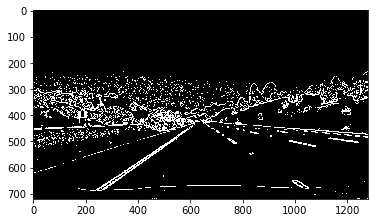

In [94]:
plt.imshow(combined_images[0], cmap='gray')

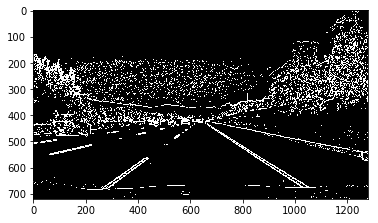

In [95]:
plt.imshow(combined_images[1], cmap='gray')

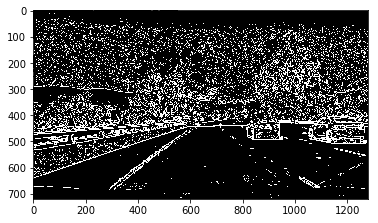

In [96]:
plt.imshow(combined_images[2], cmap='gray')

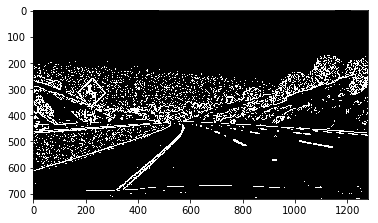

In [97]:
plt.imshow(combined_images[3], cmap='gray')

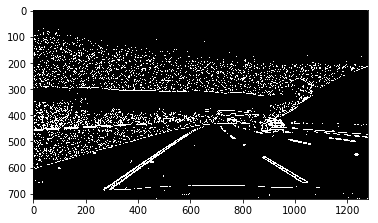

In [98]:
plt.imshow(combined_images[4], cmap='gray')

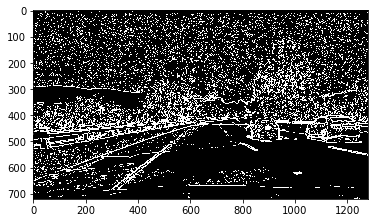

In [99]:
plt.imshow(combined_images[5], cmap='gray')

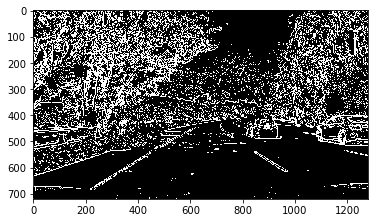

In [100]:
plt.imshow(combined_images[6], cmap='gray')

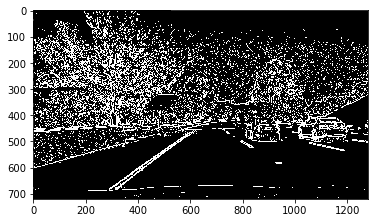

In [101]:
plt.imshow(combined_images[7], cmap='gray')

### Perspective Transform

**Requirement: Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.**

The `transform()` method creates a top-down perspective view of the road images using the defined source and destination points, defined by `get_lane_roi()` and `get_lane_dst()` funcitons respectively, and the `invert()` method re-converts to the unwarped dash-cam view.

In [102]:
def transform(image, src, dst):  
    img_size = (1280, 720)
    
    # Perform perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def invert(image, src, dst):
    img_size = (1280, 720)
    
    # Perform perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def save_top_down_images(images):
    for i in range(0, len(images)):
        mpimg.imsave('top_down_images/top_down_{}.jpg'.format(i+1),images[i])

In [103]:
### Transform to Top Down View ###
def get_lane_roi():

    TL = [702, 455] 
    TR = [1060, 680]
    BL = [260, 680]
    BR = [585, 455]
    
    return np.float32([TL, TR, BL, BR])

lane_roi = get_lane_roi()

def get_lane_dst():
    
    TL = [1030, 0]
    TR = [1030, 720]
    BR = [250, 720]
    BL = [250, 0]
    
    return np.float32([TL, TR, BR, BL])

lane_dst = get_lane_dst()

def view_top_down():
    top_down = []
    for image in combined_images:
        copy = np.copy(image)
        processed = transform(copy, lane_roi, lane_dst)
        top_down.append(processed)
        
    return top_down

top_down_images = view_top_down()
save_images(top_down_images, 'top_down')

# cv2.fillPoly(undist_test_images[6], np.int_([lane_roi]), (0,255, 0))
# plt.imshow(undist_test_images[6])

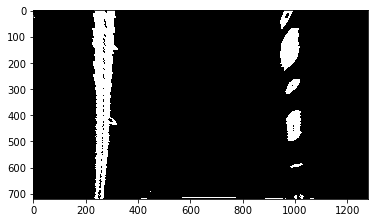

In [104]:
plt.imshow(top_down_images[0], cmap='gray')

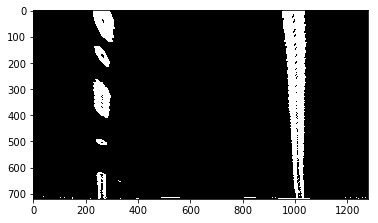

In [105]:
plt.imshow(top_down_images[1], cmap='gray')

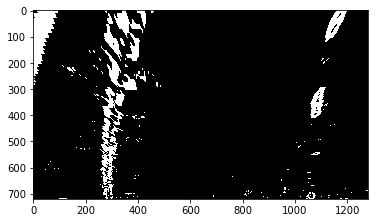

In [106]:
plt.imshow(top_down_images[2], cmap='gray')

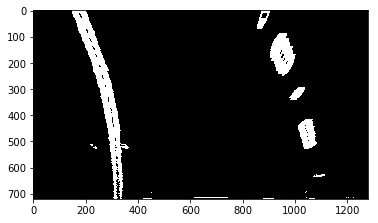

In [107]:
plt.imshow(top_down_images[3], cmap='gray')

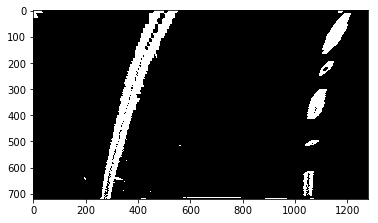

In [108]:
plt.imshow(top_down_images[4], cmap='gray')

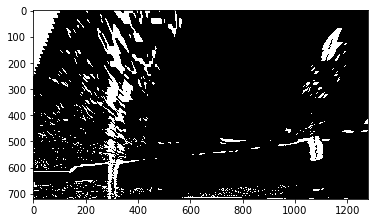

In [109]:
plt.imshow(top_down_images[5], cmap='gray')

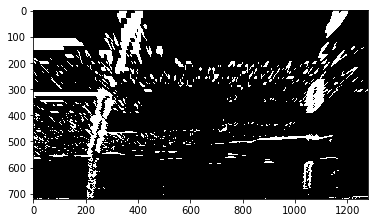

In [110]:
plt.imshow(top_down_images[6], cmap='gray')

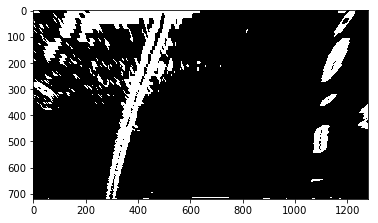

In [111]:
plt.imshow(top_down_images[7], cmap='gray')

## 3. Find Lane Lines

**Requirement: Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial.**

First I take the histogram of the lower half of each image, then find peaks in the left and right halves of the image. A windowed search is used to scan lane lines from the bottom to the top of the image. 

In [112]:
def plot_histogram(image):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    plt.plot(histogram)

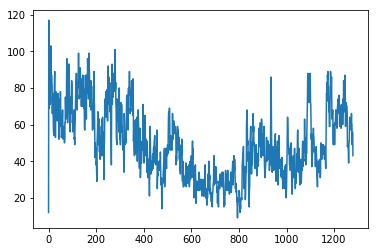

In [113]:
plot_histogram(combined_images[6])

#### Locate Lane Lines and Fit Polynomial

In [114]:
### Find Lane Lines ###
def find_lane_lines(image):
    binary_warped = np.copy(image)
    
    # Create historgram of warped image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]


        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    return binary_warped, out_img, ploty, left_fit, right_fit
    

def scan_for_lanes(images):
    scans = []
    for image in images:
        output = find_lane_lines(image)
        scans.append(output)
    return scans

def get_ploty(binary_warped):
    return np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

def get_left_fitx(left_fit, ploty):
    return left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

def get_right_fitx(right_fit, ploty):
    return right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

def plot_lane(scan):
    plt.imshow(scan[1])
    plt.plot(get_left_fitx(scan[3], scan[2]), scan[2], color='yellow')
    plt.plot(get_right_fitx(scan[4], scan[2]), scan[2], color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

lane_scans = scan_for_lanes(top_down_images)

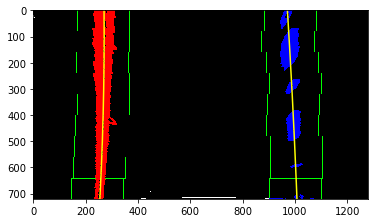

In [115]:
plot_lane(lane_scans[0])

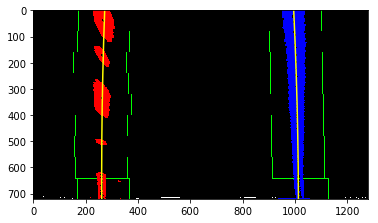

In [116]:
plot_lane(lane_scans[1])

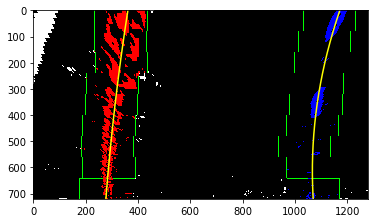

In [117]:
plot_lane(lane_scans[2])

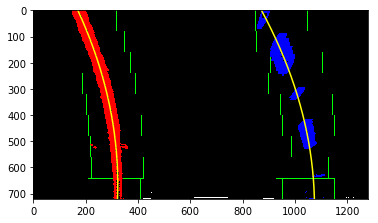

In [118]:
plot_lane(lane_scans[3])

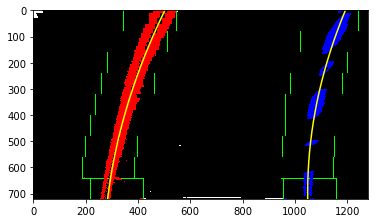

In [119]:
plot_lane(lane_scans[4])

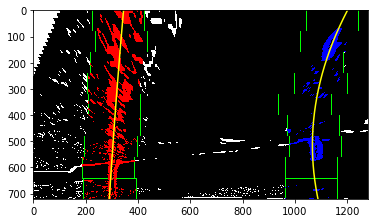

In [120]:
plot_lane(lane_scans[5])

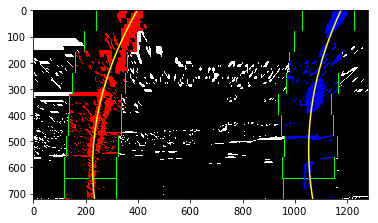

In [121]:
plot_lane(lane_scans[6])

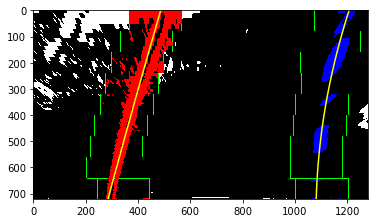

In [122]:
plot_lane(lane_scans[7])

#### Sliding Window Search

In [123]:
def slide_window(binary_warped, left_fit, right_fit):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    return window_img, out_img, left_line_pts, right_line_pts, ploty, left_fitx, right_fitx
    
def window_scan(scans):
    windows = []
    for scan in scans:
        processed = slide_window(scan[0], scan[3], scan[4]) 
        windows.append(processed)
    return windows

def plot_window(window):
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window[0], np.int_([window[2]]), (0,255, 0))
    cv2.fillPoly(window[0], np.int_([window[3]]), (0,255, 0))
    result = cv2.addWeighted(window[1], 1, window[0], 0.3, 0)
    plt.imshow(result)
    plt.plot(window[5], window[4], color='yellow')
    plt.plot(window[6], window[4], color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
windows = window_scan(lane_scans)

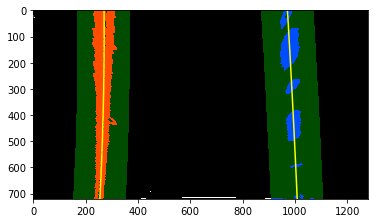

In [124]:
plot_window(windows[0])

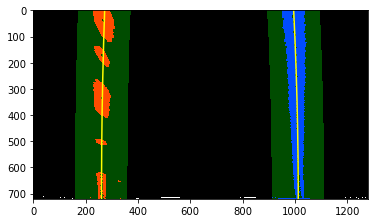

In [125]:
plot_window(windows[1])

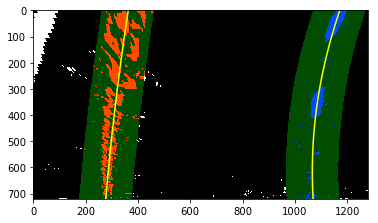

In [126]:
plot_window(windows[2])

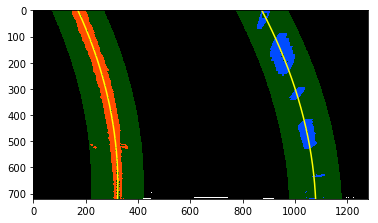

In [127]:
plot_window(windows[3])

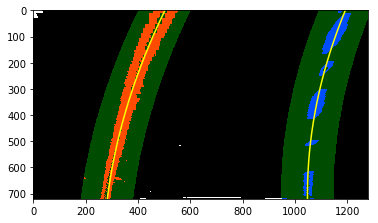

In [128]:
plot_window(windows[4])

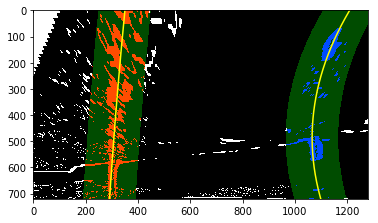

In [129]:
plot_window(windows[5])

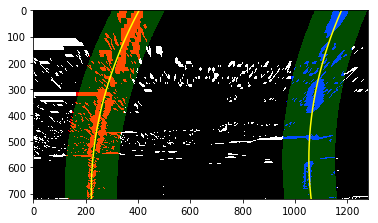

In [130]:
plot_window(windows[6])

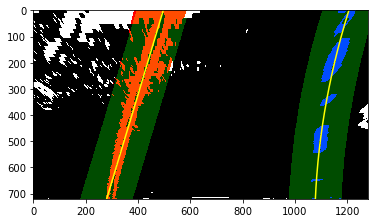

In [131]:
plot_window(windows[7])

#### Measuring Curvature

**Requirement: Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.**

Numpy's `np.polyfit()` function is used to determine the polynomial coefficients of the points defining each lane line, and the coefficients used to calculate the curvature radius of the left and right lane lines. The left and right lane base X positions are used to calculate the lane width in pixels, and converted to meters using the standard U.S. highway lane width of 3.7 meters.

In [132]:
def measure_curvature(binary_warped, ploty, left_fit, right_fit):
    # Fit a second order polynomial to pixel positions in each fake lane line
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]) #np.linspace(0, 719, num=720)# to cover same y-range as image

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Data representing lane-line pixels

    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Calculate lane width in pixels
    image_size = (1280, 720)
    left_basex = left_fit[0] * image_size[0] ** 2 + left_fit[1] * image_size[0] + left_fit[2]
    right_basex = right_fit[0] * image_size[0] ** 2 + right_fit[1] * image_size[0] + right_fit[2]

    lane_center = (left_basex + right_basex)/2
    car_center = image_size[0]/2

    # Convert to real world value
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/(right_basex - left_basex) # meters per pixel in x dimension

    center_offset = (car_center - lane_center)*xm_per_pix

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    print('Left curve radius:', left_curverad, 'm', 'Right curve radius:', right_curverad, 'm', 'Center line offset:', center_offset, 'm')
    
    return binary_warped, lefty, righty, leftx, rightx, left_fitx, right_fitx, ploty
    
def measure_lanes(images):
    measurements = []
    for image in images:
        binary_warped, out_img, ploty, left_fit, right_fit = find_lane_lines(image)
        m = measure_curvature(image, ploty, left_fit, right_fit)
        measurements.append(m)
    return measurements

def plot_measure(m):
    # Plot up the fake data
    mark_size = 3
    plt.plot(m[3], m[1], 'o', color='red', markersize=mark_size)
    plt.plot(m[4], m[2], 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(m[5], m[1], color='green', linewidth=3)
    plt.plot(m[6], m[2], color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images

lane_measurements = measure_lanes(top_down_images)

Left curve radius: 4537.49356787 m Right curve radius: 17306.821173 m Center line offset: 0.0874724191911 m
Left curve radius: 6854.15085755 m Right curve radius: 5181.07407835 m Center line offset: 0.0194859468049 m
Left curve radius: 4678.3155619 m Right curve radius: 800.318624549 m Center line offset: -0.299412150985 m
Left curve radius: 552.842459739 m Right curve radius: 571.448640372 m Center line offset: 0.191985968927 m
Left curve radius: 801.980622566 m Right curve radius: 686.629707069 m Center line offset: -0.337853621715 m
Left curve radius: 12529.562769 m Right curve radius: 460.34514796 m Center line offset: -0.66794258457 m
Left curve radius: 545.947475066 m Right curve radius: 545.23653233 m Center line offset: -0.66943491314 m
Left curve radius: 65934.4204494 m Right curve radius: 1268.77317273 m Center line offset: 0.107750074773 m


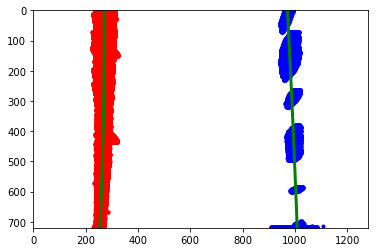

In [133]:
plot_measure(lane_measurements[0])

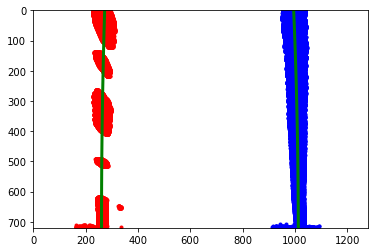

In [134]:
plot_measure(lane_measurements[1])

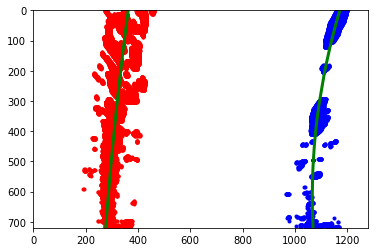

In [135]:
plot_measure(lane_measurements[2])

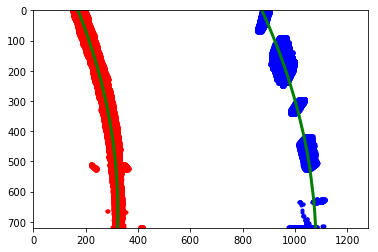

In [136]:
plot_measure(lane_measurements[3])

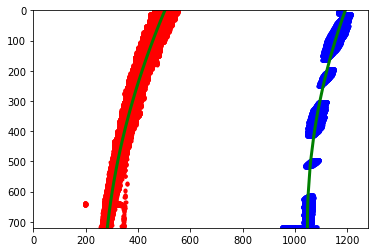

In [137]:
plot_measure(lane_measurements[4])

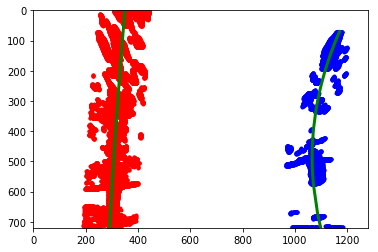

In [138]:
plot_measure(lane_measurements[5])

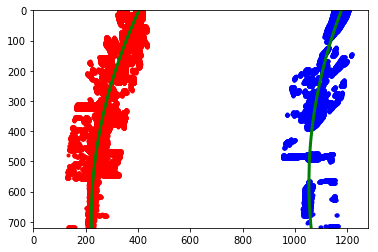

In [139]:
plot_measure(lane_measurements[6])

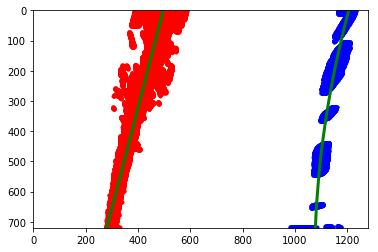

In [140]:
plot_measure(lane_measurements[7])

#### Polyfill Detected Lane Area

**Requirement: Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.**

`overlay_lane_fill()` plots the detected lane area over the unwarped image of the lane lines.

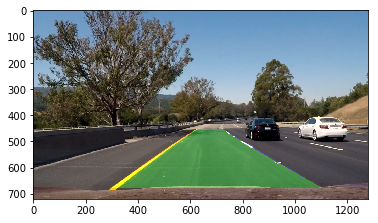

In [141]:
def overlay_lane_fill(original, warped, leftploty, rightploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, leftploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, rightploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.fillPoly(color_warp, np.int_([pts_left]), (255,0,0))
    cv2.fillPoly(color_warp, np.int_([pts_right]), (0,0,255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = invert(color_warp, lane_roi, lane_dst)
    
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    
    return result

def overlay_lanes(original_images, measurements):
    assert len(original_images) == len(measurements), "originals (%d) != scans (%d)" % (len(original_images), len(measurements))
    
    overlays = []
    for i in range(0, len(original_images)):
        m = measurements[i]
        processed = overlay_lane_fill(original_images[i], top_down_images[i], m[1], m[2], m[5], m[6])
        overlays.append(processed)
    return overlays

final_outputs = overlay_lanes(undist_test_images, lane_measurements)
save_images(final_outputs, 'final_output')

## Video Pipeline

**Criteria**

The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project.


In [142]:
from moviepy.editor import *
from IPython.display import HTML

## Lane Class

In [143]:
class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        
        # line base position in pixels
        self.basex = None
                
        # values of recent fits
        self.recent_fitted = []
                
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.curve_radius = None 
        
        #distance in meters of vehicle center from lane center
        self.alignment = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None

In [144]:
def find_lanes(frame, lane1=Lane(), lane2=Lane()):
    binary_warped = np.copy(frame)
        
    # Create lane objects to store values
    left_lane = lane1
    right_lane = lane2
    
    # Create historgram of warped image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if left_lane.detected == True and right_lane.detected == True:
        left_lane_inds = ((nonzerox > (left_lane.best_fit[0]*(nonzeroy**2) + left_lane.best_fit[1]*nonzeroy + left_lane.best_fit[2] - margin)) & (nonzerox < (left_lane.best_fit[0]*(nonzeroy**2) + left_lane.best_fit[1]*nonzeroy + left_lane.best_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_lane.best_fit[0]*(nonzeroy**2) + right_lane.best_fit[1]*nonzeroy + right_lane.best_fit[2] - margin)) & (nonzerox < (right_lane.best_fit[0]*(nonzeroy**2) + right_lane.best_fit[1]*nonzeroy + right_lane.best_fit[2] + margin)))
    else:
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window        
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    if len(left_lane_inds) > 0 and len(right_lane_inds) > 0:
        left_lane.detected = True
        right_lane.detected = True

        # Extract left and right line pixel positions
        left_lane.allx = nonzerox[left_lane_inds]
        left_lane.ally = nonzeroy[left_lane_inds] 
        right_lane.allx = nonzerox[right_lane_inds]
        right_lane.ally = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_lane.current_fit = np.polyfit(left_lane.ally, left_lane.allx, 2)
        right_lane.current_fit = np.polyfit(right_lane.ally, right_lane.allx, 2)
        
        # Calculate average coefficients over N iterations
        left_lane.recent_fitted.append(left_lane.current_fit)
        right_lane.recent_fitted.append(right_lane.current_fit)
        
        nrecents = 30 # 1 seconds video at 30 fps
        if len(left_lane.recent_fitted) > nrecents:
            left_lane.best_fit = np.mean(left_lane.recent_fitted[-nrecents:], axis=0)
            right_lane.best_fit = np.mean(right_lane.recent_fitted[-nrecents:], axis=0)
        else:
            left_lane.best_fit = np.mean(left_lane.recent_fitted, axis=0)
            right_lane.best_fit = np.mean(right_lane.recent_fitted, axis=0)
                    
        # Get fits
        left_fit = left_lane.best_fit
        right_fit = right_lane.best_fit

        # Calculate lane width in pixels
        image_size = (1280, 720)
        left_lane.basex = left_fit[0] * image_size[0] ** 2 + left_fit[1] * image_size[0] + left_fit[2]
        right_lane.basex = right_fit[0] * image_size[0] ** 2 + right_fit[1] * image_size[0] + right_fit[2]
        
        lane_center = (left_lane.basex + right_lane.basex)/2
        car_center = image_size[0]/2
        
        # Convert to real world value
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/(right_lane.basex - left_lane.basex) # meters per pixel in x dimension
        
        offset = (car_center - lane_center)*xm_per_pix
                
        # Calculate the curvature radius
        left_yeval = np.max(left_lane.ally)
        right_yeval = np.max(right_lane.ally)
        
        left_curverad = ((1 + (2*left_fit[0]*left_yeval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*right_yeval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        leftx = left_lane.allx
        rightx = right_lane.allx

        lefty = left_lane.ally
        righty = right_lane.ally

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*left_yeval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*right_yeval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        left_lane.curve_radius = left_curverad
        right_lane.curve_radius = right_curverad
        
    else:
        left_lane.detected = False
        right_lane.detected = False
        
    return left_lane, right_lane

In [145]:
test_lanes = find_lanes(top_down_images[6])

In [146]:
def plot_lanes(original, warped, lane1, lane2):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    center_offset = None
    
    if lane1.detected == True and lane2.detected == True:
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([lane1.best_fit[0]*lane1.ally**2 + lane1.best_fit[1]*lane1.ally + lane1.best_fit[2], lane1.ally]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([lane2.best_fit[0]*lane2.ally**2 + lane2.best_fit[1]*lane2.ally + lane2.best_fit[2], lane2.ally])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Get fits
        left_fit = lane1.best_fit
        right_fit = lane2.best_fit

        # Calculate lane width in pixels
        image_size = (1280, 720)
        
        lane_center = (lane1.basex + lane2.basex)/2
        car_center = image_size[0]/2
        
        # Convert to real world value
        xm_per_pix = 3.7/(lane2.basex - lane1.basex) # meters per pixel in x dimension
        
        center_offset = (car_center - lane_center)*xm_per_pix
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.fillPoly(color_warp, np.int_([pts_left]), (255,0,0))
        cv2.fillPoly(color_warp, np.int_([pts_right]), (0,0,255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = invert(color_warp, lane_roi, lane_dst)
    
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    
    # Plot radius
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Curve Radius: {:.2f} m'.format(min(lane1.curve_radius, lane2.curve_radius)),(20,100), font, 2,(255,255,255),2)
    cv2.putText(result, 'Center Alignment: {:.4f} m'.format(center_offset),(20,200), font, 2,(255,255,255),2)

    return result

#### Example Output Frame

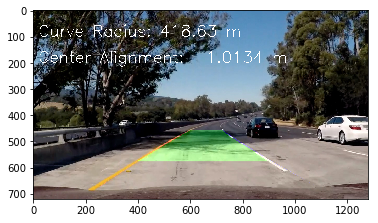

In [147]:
result = plot_lanes(undist_test_images[6], top_down_images[6], test_lanes[0], test_lanes[1])
plt.imshow(result)

#### Process Frames

In [148]:
def process_frame(image, lane1, lane2):
                
    undistort(image)
                
    s_binary = threshold_s(image)
    r_binary = threshold_red(image)
    abs_binary = threshold_abs(image)
    dir_binary = threshold_direction(image)
    mag_binary = threshold_magnitude(image)
    combined = combine_thresholds(s_binary, r_binary, abs_binary, dir_binary, mag_binary)
        
    top_down = transform(combined, lane_roi, lane_dst)
    
    lanes = find_lanes(top_down, lane1, lane2)
    
    output = plot_lanes(image, top_down, lanes[0], lanes[1])
    
    return output

#### Process Output Video

In [149]:
def process_video(input_path, output_path):
    clip  = VideoFileClip(input_path)

    new_frames = []
    
    left_lane = Lane()
    right_lane = Lane()
    
    for frame in clip.iter_frames():
        img = process_frame(frame, left_lane, right_lane)
        new_frames.append(img)
    
    new_clip = ImageSequenceClip(new_frames, fps=clip.fps)
    new_clip.write_videofile(output_path, audio=False)
    
    HTML("""
    <video width="1280" height="720" controls>
      <source src="{0}">
    </video>
    """.format(output_path))

#### Test Video

Shorter video clips extracted from the project video to test for specific conditions and faster processing.

In [150]:
short_input = 'short.mp4'
short_output = 'output_images/video_short.mp4'

process_video(short_input, short_output)

[MoviePy] >>>> Building video output_images/video_short.mp4
[MoviePy] Writing video output_images/video_short.mp4


100%|██████████| 78/78 [00:01<00:00, 62.60it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_short.mp4 



In [151]:
surface_change_input = 'mixed_surface.mp4'
surface_change_output = 'output_images/video_mixed_surface.mp4'

process_video(surface_change_input, surface_change_output)

[MoviePy] >>>> Building video output_images/video_mixed_surface.mp4
[MoviePy] Writing video output_images/video_mixed_surface.mp4


100%|██████████| 93/93 [00:01<00:00, 64.61it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_mixed_surface.mp4 



In [152]:
shadows_input = 'shadows.mp4'
shadows_output = 'output_images/video_shadows.mp4'

process_video(shadows_input, shadows_output)

[MoviePy] >>>> Building video output_images/video_shadows.mp4
[MoviePy] Writing video output_images/video_shadows.mp4


100%|██████████| 404/404 [00:10<00:00, 39.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_shadows.mp4 



**Requirement: Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).**

Below are processed video files for the project and challenge videos.

#### Project Video

In [153]:
project_input = "project_video.mp4"
project_output = "output_images/video_project.mp4"

process_video(project_input, project_output)

[MoviePy] >>>> Building video output_images/video_project.mp4
[MoviePy] Writing video output_images/video_project.mp4


100%|██████████| 1260/1260 [00:28<00:00, 44.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_project.mp4 



#### Challenge Video

In [154]:
challenge_input = "challenge_video.mp4"
challenge_output = "output_images/video_challenge.mp4"

process_video(challenge_input, challenge_output)

[MoviePy] >>>> Building video output_images/video_challenge.mp4
[MoviePy] Writing video output_images/video_challenge.mp4


100%|██████████| 485/485 [00:09<00:00, 49.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_challenge.mp4 



#### Harder Challenge Video

In [155]:
harder_challenge_input = "harder_challenge_video.mp4"
harder_challenge_output = "output_images/video_harder_challenge.mp4"

process_video(harder_challenge_input, harder_challenge_output)

[MoviePy] >>>> Building video output_images/video_harder_challenge.mp4
[MoviePy] Writing video output_images/video_harder_challenge.mp4


100%|██████████| 1199/1199 [00:33<00:00, 35.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_harder_challenge.mp4 



## Discussion

**Requirement: Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?**

**Challenges Faced**
- Shadows/High Contrast

Sharp changes in lighting conditions proved challenging by reducing the ability to fully distinguish lane lines using most thresholding techniques. Directional thresholding proved to be the most robust technique to address this issue, then combined with other thresholding techniques to improve the quality of the detection.

- Damaged/Mixed Road Surfaces

Similar to the high contrast issues resulting from sharp changes in lighting, changes in the road surface affected the accuracy of lane detection. Concrete roads were more difficult to analyze and made both color and magnitude thresholding techniques perform worse, as there was very little contrast between the surface and lane line colors. 

- Sharp Turns

Lane detection proved more difficult when navigating sharp turns, where a steep change in direction and gradient would occur.

- Obscurations

Obscurations to the camera's field of view will affect the ability to detect lane lines. Specifically, the dash-mounted camera's performance in the project video may be subject to smudges on the windscreen.

Lane detection was also affected when obscured by roadside debris (e.g. fallen leaves).

- False Detections

There were cases when the pipeline would falsely detect lanes, making them either too narrow or too wide, or following an incorrect trajectory.

I attempted to mitigate this by limiting the lane windowing based on the premise lanes are approximately 700 pixels apart when transfomed. This had adverse effects on the quality of lane detection, but is an area that can be improved.

**Improvements**

The pipelines can be improved in the following ways:
- more robustness in handling bright and dark lighting conditions
- handling high gradient (sharp) turns
- more robustness in rejecting false detections
- smoothing lane detections over video frames
